# K-means clustering using Grover's Algorithm

This notebook will show you on how to use Qiskit to solve a Quantum Machine Learning problem. Also, how to use Grover's Algorithm as an optimizer. Grover's Algorithm will be used as a subroutine of k-means clustering. As some of you already know, k-means clustering is a supervised machine learning method to optimize Euclidean distances that means find the best clustering. The function $f(x,y)$ which we would like to minimize can be described by the following equation:

$$f(x,y) = \sum\sum ||x_i - y_j||^2 $$

where $y_i$ is representing each centroid and $x_i$ represents each point (in cartesian coordinate) from our data set. For each iteration, Grover's Algorithm helps K-means to classify each point according the nearest centroid. So, we can say that Grover's is used to classify each point from input data set with time complexity $O(c\sqrt(N))$, where $c$ is a constant which is related to how much digits that composes the binary representation of Euclidean distances.

We can define what will be done in some steps:

1) Generate an input data set;

2) Create k initial random centroids which will be optimized;

3) Use Grover's Algo to classify each point according to nearest (smaller squared Euclidean distance) centroid. In this way, we are creating k sets of classified points called clusters;

4) Calculate the median for each cluster. This medians forms our new centroids;

5) Repeat steps 2), 3) and 4) untill $centroids_{i+1} = centroinds_{i}$ (stop criteria according an error $\delta$)



In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.animation as anima
import random
import networkx
import math as ma
import pandas as pd
from math import pi
from scipy.spatial import voronoi_plot_2d, Voronoi
from scipy.stats import*
import scipy.stats as stats
from sklearn import datasets
from qiskit import*
from qiskit.visualization import*
import qiskit
from qiskit import *
import numpy as np
import random
from random import choice
from qiskit.visualization import *
simulator = Aer.get_backend('qasm_simulator')

In [2]:
#Generate an input data set


#Example
data = [[0.1,0.1],[0.2,0.2],[0.15,0.1],[0.4,0.4],[0.6,0.6],[0.4,0.5],[0.9,0.9],[0.8,0.8],[0.85,0.8],[0.1,0.9],[0.1,0.7],[0.2,0.9]]
x = []
y = []
for i in range(len(data)):
    x.append(data[i][0])
    y.append(data[i][1])


In [3]:
#Define k=4 initial random centroids


#Example for k=4 (4-means)
centroids = [[random.random(), random.random()], 
             [random.random(), random.random()], 
             [random.random(), random.random()], 
             [random.random(), random.random()]]

In [4]:
center_x = []
center_y = []
for i in range(len(centroids)):
    center_x.append(centroids[i][0])
    center_y.append(centroids[i][1])
    

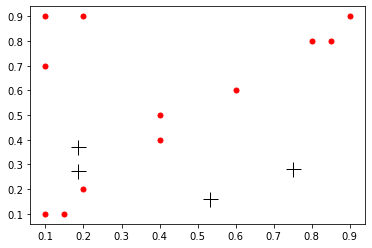

In [5]:
plt.plot(x,y,'ro',markersize = 5)
plt.plot(center_x,center_y,'k+',markersize = 15)


### Grover's Algorithm to find mininum

In order to use Grover's Algorithm to find a mininum in a classical data set, one proposal is to use a “quantum RAM,” typically meaning a large classical memory which can be queried in superposition [1]. It can be easily builded using an equivalent quantum circuit which classical data is stored in a quantum register. In this application, classical data would be the Euclidean distances between each point of the coreset and the k-means centroids. So, if there are $k$ centroids, there are $k$ distances stored in the Quantum RAM. The image bellow represents a quantum circuit equivalent to a qRAM where each Euclidean distance $x_j$ is indexed by $j$.

<img src="files/qram.png" width="800" height="400">

The full quantum circuit for Grover's Algorithm is showed in the figure bellow.

<img src="files/grover.png" width="800" height="400">

Phase flip is an iterative function which analise the most significant qubits of the measured value and apply phase inversion on the distances which are smaller than the measured value. In order to make it more clear, let's see an example on how it works. 

Let's suppose $distances = [9,5,19,20,17,22,23,29,31,44,52,55,57,73,4,12,125,48,56,33,22,77,48,54,50,122,111,31,32,69,93,97,94,101,105,110,111,126,127,22,33,44,55,66,77,88,99,100,11123,43,54,65,76,87,98,7,6,8,11,63]$. If we measure randomly 125 = 0b1111101, we know that if we apply the phase inversion in all states that contains '0' (0b0______) in the most significant qubit, all these marked states will have decimal values less than the measured value 125. We can mark all states with a single operation, due to the superposition of states in Quantum RAM. The Diffuser operator $U = 2|\phi\rangle \langle \phi| - 1 $ will act in this state performing an inversion about the mean, increasing the probability to measure one of these marked states (with equal probability). If the next measured value is i.e. 12 = 0b0001100, we must mark states all states such that the four most signicant qubits are '0' (0b0000___). Then, after measurement, possible measured values are 4 and 5. If we measure 5 = 0b0000101, we search for states which has this binary representation: 0b00000__ but when we measure probably we'll measurea number greater than 5 because there is no numbers like 0b00000__ so it means that the mininum is between $5$ and $2^2$. Let's see, in the figure bellow, how we can perform the iterative phase flip function. This logic can be used for any data sets.

<img src="files/phaseflip.png" width="800" height="400">


For each iteration Grover's perform $\sqrt N$ iterations. So, it takes time $O(c \sqrt N) \equiv O(\sqrt N) $ where $c$ is, in the worst case, the number of bits of the first measured value. 


## Implementing with Qiskit

In [6]:
#The function bellow implements Grovers Algo to find a minimum in a classical data set.

def Grover(distt):      
    T = []
    for m in range(len(distt)):
        T.append(list(f'{distt[m]:011b}'))
    for m in range(len(T)):
        for n in range(len(T[m])):
            T[m][n] = int(T[m][n])
            
    reg1 = 3 #stores indexes values 'j'
    reg2 = 10 #stores T(j) generating sum |j>|T(j)>
    
    aux = 1 #ancilla
    n = reg1+reg2+aux
    
    def qram():
        #cost_list = []
        mem = QuantumCircuit(n)
        
        mem.x([0,1,2])
        for i in range(reg2):
            if(T[0][i]==1):
                mem.mct([0,1,2],3+i)
        mem.x([0,1,2])
        mem.barrier()

        mem.x([0,1])
        for i in range(reg2):
            if(T[1][i]==1):
                mem.mct([0,1,2],3+i)
        mem.x([0,1])
        mem.barrier()

        
        mem.x([0,2])
        for i in range(reg2):
            if(T[2][i]==1):
                mem.mct([0,1,2],3+i)
        mem.x([0,2])
        mem.barrier()

        mem.x([0])
        for i in range(reg2):
            if(T[3][i]==1):
                mem.mct([0,1,2],3+i)
        mem.x([0])
        mem.barrier()  

        mem.x([1,2])
        for i in range(reg2):
            if(T[4][i]==1):
                mem.mct([0,1,2],3+i)
        mem.x([1,2])
        mem.barrier()


        mem.x([1])
        for i in range(reg2):
            if(T[5][i]==1):
                mem.mct([0,1,2],3+i)
        mem.x([1])
        mem.barrier()

        mem.x([2])
        for i in range(reg2):
            if(T[6][i]==1):
                mem.mct([0,1,2],3+i)
        mem.x([2])
        mem.barrier()


        for i in range(reg2-1):
            if(T[7][i]==1):
                mem.mct([0,1,2],3+i)

        mem.barrier()
        return mem
    #############################################################
    def diffuser():

        diff = QuantumCircuit(reg1)
        diff.h(range(reg1))
        diff.x(range(reg1))
        diff.h(reg1-1)
        diff.mct([0,1],2)
        diff.h(reg1-1)
        diff.x(range(reg1))
        diff.h(range(reg1))
        diff.barrier()

        return diff
    current_min = np.random.choice(distt)
    pos = distt.index(current_min)
    control=[]
    control2=[]
    count = []
    curr_min = []
    current_min

    for i in range(reg2):
        if(T[pos][i]==0):
            control.append(i+reg1)
            control2.append(i+reg1)
        if(T[pos][i]==1):
            control.append(i+reg1)
            control2.append(i+reg1)
            break
    for i in range(reg2):

        qc=QuantumCircuit(n,reg1)

        # INITIALIZE
        qc.h(range(reg1))
        qc.x(n-1)
        qc.h(n-1)
        qc.barrier()
        # END INITIALIZE
        ################### FIRST GROVER ITERATION ##########################

        # STORES cost_list in reg2
        qc = qc.compose(qram())
        # END STORAGE


        # FLIP PHASE
        qc.x(control2)
        qc.mct(control,n-1)
        qc.x(control2)
        qc.barrier()
        # END FLIP PHASE

        # UNCOMPUTE qRAM
        qc = qc.compose(qram())
        # END UNCOMPUTE

        # DIFFUSER
        qc = qc.compose(diffuser())
        # END DIFFUSER       
        
        ############################# END GROVER ITERATIONS #############################

        # CHANGE ORDER OF QUBITS
        qc.swap(0,2)

        # MEASUREMENT
        qc.measure(range(reg1),range(reg1))

        # EXECUTE
        counts = execute(qc, backend=simulator, shots=1).result().get_counts(qc)

        # BINARY TO DECIMAL
        for measured_value in counts:
            a=int(measured_value[::1], 2)        
        
        if((distt[a]<current_min) and (len(count)==0)):

            current_min = distt[a]

            control.append(len(control)+reg1)
            control2.append(len(control2)+reg1)

        elif(distt[a]>=current_min):

            count.append(0)

            control.append(len(control)+reg1)

            if(len(count)==1):
                control2[len(control2)-1]=control2[len(control2)-1]+1

            else:
                control2.append(control2[len(control2)-1]+1)

        if(control[len(control)-1]==10):
            break

        curr_min.append(distt[a])

    mini = min(curr_min)
    print('minimum distance: ',mini)

    return distt.index(mini)  



## Put it all together

Here, Grover's Algorithm is used as a subroutine of 4-means method as explained previously.

In [7]:
for l in range(3):
    print(centroids)
    distances = []    
    for j in range(len(data)):
        distt=[]
        for i in range(len(centroids)):
            distt.append(round(((centroids[i][0] - data[j][0])**2 + (centroids[i][1] - data[j][1])**2)*1000))

        distt.append(1023)
        distt.append(1022)
        distt.append(1021)
        distt.append(1020)

        distances.append(distt)

    c0 = []
    c1 = []
    c2 = []
    c3 = []

    for i in range(len(distances)):

        '''indexx = distances[i].index(min(distances[i]))'''
        indexx = Grover(distances[i])
        if(indexx==0):
            c0.append(data[i])

        if(indexx==1):
            c1.append(data[i])

        if(indexx==2):
            c2.append(data[i])

        if(indexx==3):
            c3.append(data[i])

    cs=[c0,c1,c2,c3]
    for n in range(len(cs)):
        sumx = 0
        for k in range(len(cs[n])):
            sumx = sumx + cs[n][k][0]


        sumy = 0
        for k in range(len(cs[n])):
            sumy = sumy + cs[n][k][1]
        try:
            newcentroid = [sumx/len(cs[n]) , sumy/len(cs[n])]
        except IOError:
            continue
        except ZeroDivisionError:
            continue


        centroids[n] = newcentroid
    


        

[[0.18447579400947334, 0.2743084502779847], [0.5326379495766284, 0.16235368473877276], [0.18513446368114306, 0.37049419310985177], [0.7502870168715059, 0.280659263459312]]
minimum distance:  1020
minimum distance:  29
minimum distance:  32
minimum distance:  74
minimum distance:  125
minimum distance:  63
minimum distance:  406
minimum distance:  272
minimum distance:  280
minimum distance:  806
minimum distance:  188
minimum distance:  281
[[0.125, 0.39999999999999997], [0.4, 0.4], [0.26666666666666666, 0.5333333333333333], [0.65, 0.7999999999999999]]
minimum distance:  91
minimum distance:  46
minimum distance:  91
minimum distance:  0
minimum distance:  42
minimum distance:  10
minimum distance:  73
minimum distance:  23
minimum distance:  40
minimum distance:  162
minimum distance:  56
minimum distance:  139
[[0.15000000000000002, 0.13333333333333333], [0.4, 0.45], [0.13333333333333333, 0.8333333333333334], [0.7875, 0.7749999999999999]]
minimum distance:  4
minimum distance:  7
min

In [8]:
#best clustering

centroids

[[0.15000000000000002, 0.13333333333333333],
 [0.5, 0.5],
 [0.2, 0.7499999999999999],
 [0.8500000000000001, 0.8333333333333334]]

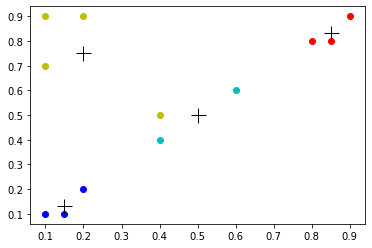

In [10]:
center_x = []
center_y = []
for i in range(len(centroids)):
    center_x.append(centroids[i][0])
    center_y.append(centroids[i][1])


c0x=[]
c0y=[]

for i in range(len(c0)):
    c0x.append(c0[i][0])
    c0y.append(c0[i][1])
    
c1x=[]
c1y=[]

for i in range(len(c1)):
    c1x.append(c1[i][0])
    c1y.append(c1[i][1])
    
c2x=[]
c2y=[]

for i in range(len(c2)):
    c2x.append(c2[i][0])
    c2y.append(c2[i][1])
    
c3x=[]
c3y=[]

for i in range(len(c3)):
    c3x.append(c3[i][0])
    c3y.append(c3[i][1])
    

plt.plot(c0x,c0y,'bo')
plt.plot(c1x,c1y,'co')
plt.plot(c2x,c2y,'yo')
plt.plot(c3x,c3y,'ro')
plt.plot(center_x,center_y,'k+',markersize=15)

## Conclusions

The figure above shows us the best clustering for this 4-means example. The centroids are distributed so that the sum of all Euclidean disntances is minimized. This 